## Downloading Dataset

In [ ]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name

project_name = 'playground-series-s3e25'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
token = {"username":userdata.get("Kaggle_Username"),"key":userdata.get("Kaggle")}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
# !rm -df train.csv test.csv sample_submission.csv
!unzip $project_name && rm -d $project_name
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [ ]:
!gdown 14_qTAMSJW7i3cEjF2NBT3uaQUw6y1mdF

Downloading...
From: https://drive.google.com/uc?id=14_qTAMSJW7i3cEjF2NBT3uaQUw6y1mdF
To: /content/Original.csv
100% 103k/103k [00:00<00:00, 112MB/s]


## Data Description

|ID| Name |  Feature Description|
|--|------|------------------------|
|0 |allelectrons_Total| Total number of electrons
|1 |density_Total |Total elemental density
|2 |allelectrons_Average |Atomic average number of electrons
|3 |val_e_Average |Atomic average number of valence electrons
|4 |atomicweight_Average |Atomic average atomic weight
|5 |ionenergy_Average |Atomic average first IE
|6 |el_neg_chi_Average |Atomic average Pauling electronegativity of the most common oxidation state
|7 |R_vdw_element_Average| Atomic average van der Waals atomic radius
|8 |R_cov_element_Average| Atomic average covalent atomic radius
|9 |zaratio_Average| Atomic average atomic number to mass number ratio
|10 |density_Average| Atomic average elemental density


Note:
- [Research Paper](https://sci-hub.se/10.1021/bk-2019-1326.ch002)
- Bond strength can be modeled as an electron binding force related to
first IE through a Hooke’s law potential energy relationship, $$k=\frac{IE}{2r^2_{eff}}$$ where $r_{eff}$ is the effective ionic radii.
- The atomic number to mass number ratio (Z/A)is directly related to the total electron crosssection, or the effective electronic energy-absorption cross section of an individual element.


In [1]:
from sklearn.neighbors import VALID_METRICS

# Get valid metrics for KD tree
valid_metrics_kd_tree = sorted(VALID_METRICS['kd_tree'])
print(valid_metrics_kd_tree)


['chebyshev', 'cityblock', 'euclidean', 'infinity', 'l1', 'l2', 'manhattan', 'minkowski', 'p']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

In [ ]:
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

## Custom Code

### Metrics Definition

In [ ]:
def medAE(y_true,y_pred):
    return np.median(np.abs(y_true-y_pred))

### Preprocessing for test

In [ ]:
def preprocess(features, scaling_x):
    pass

### Selecting Primary Model

In [ ]:
def selection_primary_model(models,x_train,y_train, x_test, y_test, custom_scoring=medAE):
    report = {
        'model_name': [],
        'train_score': [],
        'test_score': [],
        'custom_train_score': [],
        'custom_test_score': []
    }

    for model in models.keys():
        report['model_name'] += [model]
        # predictor =
        models[model].fit(x_train,y_train)
        train_y_predicted = models[model].predict(x_train)
        test_y_predicted = models[model].predict(x_test)
        report['train_score'].append(models[model].score(x_train,y_train))
        report['test_score'].append(models[model].score(x_test,y_test))
        report['custom_train_score'].append(custom_scoring(y_train, train_y_predicted))
        report['custom_test_score'].append(custom_scoring(y_test,test_y_predicted))

    return pd.DataFrame(report).sort_values('custom_train_score')

### Plotting Test and Train Data Error - To understand how our model can predict about dataset

In [ ]:
def train_test_prediction_plot(train_y,train_y_pred,test_y,test_y_pred,points=200):
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(range(points),train_y[:points],range(points), train_y_pred[:points],'--')
    plt.legend(['true','predicted'])
    plt.subplot(2,1,2)
    plt.plot(range(points),test_y[:points], range(points), test_y_pred[:points],'--')
    plt.legend(['true','predicted'])

def error_plot(train_y, train_y_pred,points=200):
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.stem(range(points),train_y[:points]- train_y_pred[:points])
    plt.ylabel("Error")
    plt.legend(['true-predicted'])
    plt.subplot(2,1,2)
    plt.stem(range(points),test_y[:points] - test_y_pred[:points],)
    plt.ylabel("Error")
    plt.legend(['true-predicted'])


## Preprocessing

In [ ]:
train_data = pd.read_csv("train.csv").drop('id',axis=1)
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [ ]:
train_data.shape

(10407, 12)

In [ ]:
train_data.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [ ]:
train_data.drop_duplicates(inplace=True)

In [ ]:
train_data.shape

(10407, 12)

In [ ]:
train_data.nunique()

allelectrons_Total        325
density_Total            1099
allelectrons_Average      629
val_e_Average             205
atomicweight_Average      849
ionenergy_Average         898
el_neg_chi_Average        745
R_vdw_element_Average     737
R_cov_element_Average     698
zaratio_Average           815
density_Average           599
Hardness                   50
dtype: int64

In [ ]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.0,0.493349,0.063080,0.0,0.476196,0.488550,0.496070,0.825990


Observation:
- Values can not be zero and those can be treated as missing data. Yo need to just fill those data.
- What could be way of filling those data?
- All electrons must have outliers. so we need to treat them.

In [ ]:
(train_data==0).sum()

allelectrons_Total       76
density_Total            54
allelectrons_Average     76
val_e_Average            71
atomicweight_Average     77
ionenergy_Average        73
el_neg_chi_Average       67
R_vdw_element_Average    68
R_cov_element_Average    77
zaratio_Average          62
density_Average          56
Hardness                  0
dtype: int64

In [ ]:
(train_data==0).sum()/len(train_data)

allelectrons_Total       0.007303
density_Total            0.005189
allelectrons_Average     0.007303
val_e_Average            0.006822
atomicweight_Average     0.007399
ionenergy_Average        0.007015
el_neg_chi_Average       0.006438
R_vdw_element_Average    0.006534
R_cov_element_Average    0.007399
zaratio_Average          0.005958
density_Average          0.005381
Hardness                 0.000000
dtype: float64

In [ ]:
fig,axes = plt.subplots(12,2,figsize=(15, 40),dpi=300)

for ind,col in enumerate(train_data.columns):
    plt.subplot(12,2,2*ind+1)
    sns.histplot(train_data[col],bins=15,kde=True)
    # plt.gca().set_title(col)

    plt.subplot(12,2,2*ind+2)
    sns.boxplot(train_data[col],orient="h")
    plt.gca().set_title(col)

fig.tight_layout()
plt.show()

In [ ]:
cols = train_data.drop('Hardness',axis=1).columns
fig,axes = plt.subplots(12,2,figsize=(15, 40),dpi=300)
for i in range(len(cols)):
    plt.subplot(6,2,i+1)
    plt.scatter(train_data[cols[i]],train_data['Hardness'])
    plt.axvline(train_data.Hardness.quantile(.99), color='red', linestyle='--',linewidth=2)
    plt.xlabel(cols[i])
    plt.ylabel('Hardness')
    plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

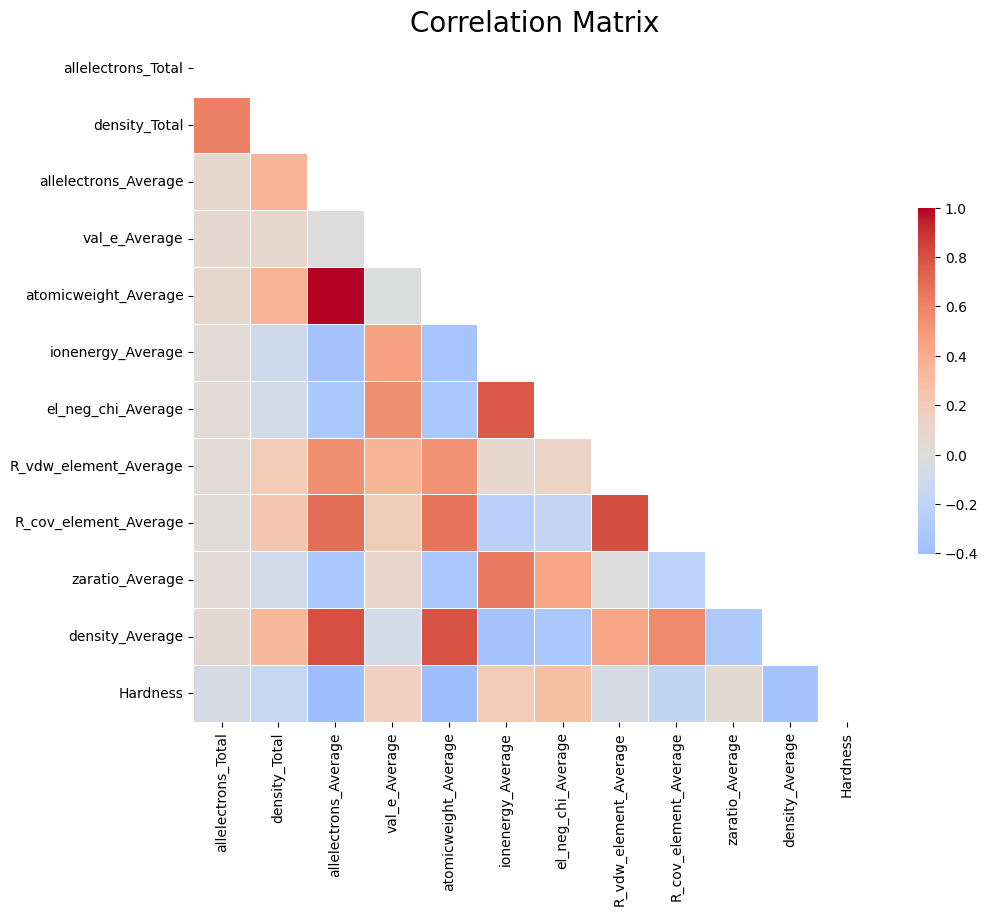

In [ ]:
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', fontsize=20)
plt.savefig("Correlation matrix.png")
plt.show()

In [ ]:
corr.style.background_gradient(cmap='coolwarm')

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
allelectrons_Total,1.000000,0.616092,0.074725,0.071618,0.078489,0.034883,0.036897,0.038551,0.024420,0.031035,0.058067,-0.061687
density_Total,0.616092,1.000000,0.356399,0.083640,0.355614,-0.104870,-0.075535,0.202331,0.240787,-0.089792,0.336046,-0.161524
allelectrons_Average,0.074725,0.356399,1.000000,0.004376,0.990660,-0.360046,-0.319413,0.550669,0.688680,-0.328973,0.803641,-0.400496
val_e_Average,0.071618,0.083640,0.004376,1.000000,0.001860,0.453901,0.550007,0.354538,0.189352,0.093854,-0.068899,0.161715
atomicweight_Average,0.078489,0.355614,0.990660,0.001860,1.000000,-0.356640,-0.316053,0.529277,0.666165,-0.327459,0.796564,-0.402948
ionenergy_Average,0.034883,-0.104870,-0.360046,0.453901,-0.356640,1.000000,0.774050,0.078650,-0.235344,0.638616,-0.359735,0.203203
el_neg_chi_Average,0.036897,-0.075535,-0.319413,0.550007,-0.316053,0.774050,1.000000,0.121926,-0.174485,0.441195,-0.322099,0.290352
R_vdw_element_Average,0.038551,0.202331,0.550669,0.354538,0.529277,0.078650,0.121926,1.000000,0.811823,0.002984,0.439990,-0.061402
R_cov_element_Average,0.024420,0.240787,0.688680,0.189352,0.666165,-0.235344,-0.174485,0.811823,1.000000,-0.221164,0.571741,-0.189111
zaratio_Average,0.031035,-0.089792,-0.328973,0.093854,-0.327459,0.638616,0.441195,0.002984,-0.221164,1.000000,-0.306644,0.055248


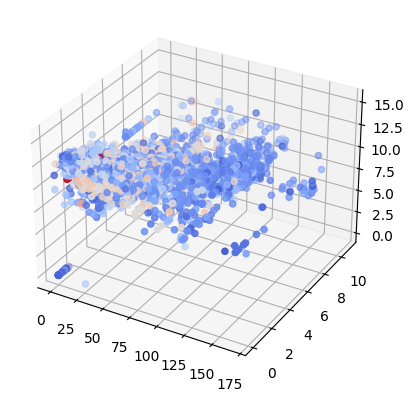

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection ='3d')
# x,y,z,c = train_data['atomicweight_Average'],train_data['density_Average'],train_data['el_neg_chi_Average'],train_data['Hardness']
x,y,z,c = train_data['atomicweight_Average'],train_data['density_Average'],train_data['ionenergy_Average'],train_data['Hardness']

ax.scatter(x, y, z, c = c, cmap='coolwarm')
plt.show()

In [ ]:
fig = px.histogram(train_data,x = "Hardness",nbins=10)
fig.update_layout(bargap=.3)
fig.show(renderer='colab')

In [ ]:
train_data[(train_data['allelectrons_Total']>1800)]

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
65,1894.0,25.021992,7.944444,4.388889,16.210699,11.467522,2.688333,1.544444,0.735556,0.601609,0.54957,2.5
774,9852.0,8.511159,7.636364,3.676768,15.374870,13.123610,2.780505,1.385051,0.458788,0.706986,1.04032,2.8
871,3328.0,4.907327,10.000000,4.666667,20.027353,11.614333,2.817333,1.705000,0.980000,0.491673,0.86724,5.5
1423,3328.0,4.243996,7.600000,4.800000,15.693100,12.415840,2.828000,1.598000,0.836000,0.499196,0.75193,5.5
2597,3328.0,25.494000,18.000000,4.800000,43.498522,10.759120,2.279000,1.907200,0.946000,0.485063,1.20466,3.5
3072,2024.2,236.459656,48.172299,2.681514,114.951853,7.146097,1.622865,2.209848,1.615840,0.434283,0.45291,4.7
4629,3328.0,36.136971,10.875000,4.625000,22.206043,12.184250,2.640625,1.787813,0.940000,0.493379,1.76740,5.5
5280,3328.0,7.442831,8.000000,4.000000,17.790357,11.475770,2.799000,1.750000,0.828000,0.499680,0.53914,4.0
5493,15300.0,643.093804,8.027397,5.401274,16.215127,12.976603,3.179236,1.567945,0.737260,0.505030,0.58105,1.5
6591,1894.0,25.982136,8.417778,5.333333,16.839527,13.265820,3.321600,1.556178,0.680356,0.504142,0.50430,4.8


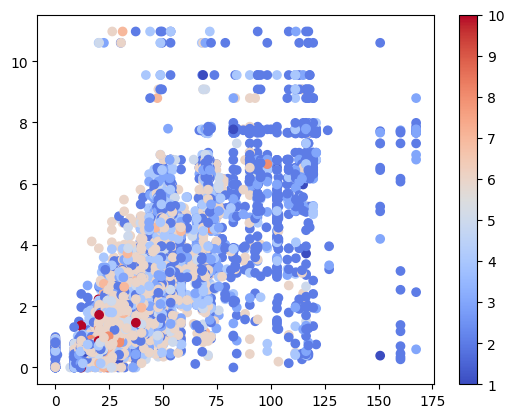

In [ ]:
plt.scatter(train_data['atomicweight_Average'],train_data['density_Average'],c=np.round(train_data['Hardness']),cmap='coolwarm')
plt.colorbar()
plt.show()

### Group 1 and Group 2 is formed.

In [ ]:
group1 = train_data[train_data.all(axis='columns')]
group2 = train_data[~train_data.all(axis='columns')]

In [ ]:
group1

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


In [ ]:
group2

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
22,0.0,0.755433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.80454,2.5
99,42.0,0.000000,0.000000,4.000000,0.000000,0.026725,2.727000,1.767000,0.000000,0.000000,0.80212,6.0
272,198.0,9.148824,4.814815,3.459459,8.462067,13.266033,2.065000,1.394000,0.574595,0.770755,0.00000,2.0
390,40.0,1.743160,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.00000,5.0
524,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50633,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
10237,30.0,4.542664,11.000000,4.666667,22.521872,12.392110,2.766667,1.625000,0.000000,0.499074,1.02048,4.8
10242,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82753,1.5
10321,0.0,0.505992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499404,0.01079,6.5
10378,120.0,15.550000,12.000000,4.000000,26.024935,10.600980,2.644000,1.794000,0.926000,0.499010,0.00000,5.0


In [ ]:
group1.isna().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [ ]:
group2.isna().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [ ]:
(group1==0).sum()/len(group1)

allelectrons_Total       0.0
density_Total            0.0
allelectrons_Average     0.0
val_e_Average            0.0
atomicweight_Average     0.0
ionenergy_Average        0.0
el_neg_chi_Average       0.0
R_vdw_element_Average    0.0
R_cov_element_Average    0.0
zaratio_Average          0.0
density_Average          0.0
Hardness                 0.0
dtype: float64

In [ ]:
(group2==0).sum()/len(group2)

allelectrons_Total       0.633333
density_Total            0.450000
allelectrons_Average     0.633333
val_e_Average            0.591667
atomicweight_Average     0.641667
ionenergy_Average        0.608333
el_neg_chi_Average       0.558333
R_vdw_element_Average    0.566667
R_cov_element_Average    0.641667
zaratio_Average          0.516667
density_Average          0.466667
Hardness                 0.000000
dtype: float64

In [ ]:
group1.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10287.0,129.162529,225.029924,0.895000,68.000000,100.000000,131.000000,15300.000000
density_Total,10287.0,14.629141,16.000044,0.133873,7.558488,10.803992,16.676996,643.093804
allelectrons_Average,10287.0,17.190811,10.407763,4.040404,10.000000,12.600000,22.000000,67.000000
val_e_Average,10287.0,4.580480,0.579476,1.333333,4.000000,4.750000,4.800000,6.000000
atomicweight_Average,10287.0,37.863012,25.918982,0.913180,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10287.0,11.016655,1.051025,7.146097,10.599905,11.217767,11.674017,15.245810
el_neg_chi_Average,10287.0,2.625773,0.259759,1.622865,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10287.0,1.743053,0.131310,1.028000,1.672500,1.734167,1.811562,2.250000
R_cov_element_Average,10287.0,0.951419,0.160263,0.120000,0.865000,0.918333,0.982500,1.615840
zaratio_Average,10287.0,0.496095,0.050047,0.401635,0.476196,0.488550,0.496070,0.825990


In [ ]:
group2.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,120.0,32.983350,79.076914,0.0,0.0,0.00000,36.500000,466.000000
density_Total,120.0,2.678457,6.311620,0.0,0.0,0.02350,1.740168,37.007299
allelectrons_Average,120.0,3.523901,5.861419,0.0,0.0,0.00000,6.000000,36.666667
val_e_Average,120.0,1.658619,2.049965,0.0,0.0,0.00000,4.000000,6.000000
atomicweight_Average,120.0,7.048777,12.442360,0.0,0.0,0.00000,11.990560,82.598467
ionenergy_Average,120.0,4.222057,5.650186,0.0,0.0,0.00000,11.082955,13.652933
el_neg_chi_Average,120.0,1.055131,1.231576,0.0,0.0,0.00000,2.489500,2.986667
R_vdw_element_Average,120.0,0.726384,0.847998,0.0,0.0,0.00000,1.545000,2.250000
R_cov_element_Average,120.0,0.319451,0.464318,0.0,0.0,0.00000,0.710000,1.500000
zaratio_Average,120.0,0.257928,0.273700,0.0,0.0,0.00000,0.499026,0.770755


### Group 1 Analysis


#### Claim 1: R_vdw_element_Average > R_cov_element_Average

In [ ]:
group1[(group1['R_vdw_element_Average'] <= group1['R_cov_element_Average'])]

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
716,70.0,1.740168,4.583333,4.333333,8.711005,13.161829,2.595000,1.318667,1.363333,0.765010,0.78534,1.5
1155,70.0,2.008328,4.666667,2.666667,8.773227,11.614333,1.903333,1.310000,1.363333,0.745029,0.40528,1.8
4369,70.0,1.740168,5.400000,3.200000,10.612526,8.319960,2.020000,1.330000,1.422000,0.663797,0.43320,3.8
7810,108.0,8.228992,23.000000,5.600000,49.204038,10.759120,2.572000,1.028000,1.028000,0.491714,2.01939,2.5
9931,36.0,8.903332,18.000000,4.000000,37.346215,9.706000,2.675000,1.045000,1.300000,0.488550,0.92400,3.8
10399,36.0,8.903332,18.000000,4.000000,37.346215,12.415840,2.675000,1.545000,1.545000,0.614430,1.46035,10.0


#### Adding new features

In [ ]:
train_df = group1.drop("Hardness", axis=1)
for i in train_df.columns:
    train_df[f"lnx_{i}"] = train_df[i].apply(lambda x: np.log(x))

## Eta is defined as compact ratio
train_df['no_atoms'] = train_df['allelectrons_Total']/train_df['allelectrons_Average']
train_df['eta'] = train_df['density_Total']/(train_df['density_Average']*train_df['no_atoms'])
train_df['inverse_R_vdw'] = 1/train_df['R_vdw_element_Average']
train_df['inverse_R_cov'] = 1/train_df['R_cov_element_Average']

train_df.shape

(10287, 26)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3, include_bias=False)
new_data = poly.fit_transform(train_df)

In [ ]:
new_data.shape

(10287, 3653)

In [ ]:
new_df = pd.DataFrame(new_data, columns= poly.get_feature_names_out())
new_df['Hardness'] = group1['Hardness']
new_df.head().iloc[:,:5]

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average
0,100.0,0.841611,10.0,4.8,20.612526
1,100.0,7.558488,10.0,4.8,20.298893
2,76.0,8.885992,15.6,5.6,33.739258
3,100.0,8.795296,10.0,4.8,20.213349
4,116.0,9.577996,11.6,4.8,24.988133


In [ ]:
new_df.isna().sum()

allelectrons_Total                 0
density_Total                      0
allelectrons_Average               0
val_e_Average                      0
atomicweight_Average               0
                                ... 
inverse_R_vdw^3                    0
inverse_R_vdw^2 inverse_R_cov      0
inverse_R_vdw inverse_R_cov^2      0
inverse_R_cov^3                    0
Hardness                         117
Length: 3654, dtype: int64

In [ ]:
group1['Hardness'].isna().sum()

0

In [ ]:
drop_cols = [

]
extracted = new_df.drop(drop_cols, axis=1)
extracted.shape

(10287, 3654)

In [ ]:
# corr = new_df.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# name = 'Correlation Matrix of Polynomial Features'
# plt.title(name, fontsize=20)
# plt.savefig(f"{name}.png")
# plt.show()

### Selecting some new feature

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
drop_cols = ['Hardness',
            #  'allelectrons_Average'
             ]
data_x=scaler.fit_transform(new_df.drop(drop_cols,axis=1))
data_y= group1['Hardness']
train_x, test_x, train_y, test_y = train_test_split(data_x,data_y, random_state=42)

In [ ]:
lr = LinearRegression(n_jobs=-1)
lr.fit(train_x,train_y)
lr.score(train_x,train_y), lr.score(test_x,test_y)

(0.7198967857263745, -8947622885.006655)

In [ ]:
medAE(train_y,lr.predict(train_x)), medAE(test_y,lr.predict(test_x)),

(0.3837890625, 1.24814453125)

In [ ]:
ls = Lasso(alpha=.0005,max_iter=int(2e4))
ls.fit(train_x,train_y)
ls.score(train_x,train_y), ls.score(test_x,test_y)

(0.3489302232231408, 0.35507726947544704)

|alpha|train_score|test_score|
|-----|-----------|----------|
|.001| 0.33239483575495343| 0.3429241671064055|

In [ ]:
medAE(train_y,ls.predict(train_x)), medAE(test_y,ls.predict(test_x)),

(0.8211543780513111, 0.8038142723634172)

In [ ]:
ls.intercept_

-8.10888237198656

In [ ]:
ls.coef_.shape

(3653,)

In [ ]:
important_features  = pd.DataFrame({"Features": new_df.columns[:-1],
              "Coefficient": ls.coef_,
              "L1 weightage": np.abs(ls.coef_)/np.sum(np.abs(ls.coef_))
              }).sort_values(by='Coefficient',key=lambda x: abs(x), ascending = False).reset_index(drop=True)


In [ ]:
important_features.head(100)

,Features,Coefficient,L1 weightage
0,lnx_val_e_Average^3,9.067695,0.116152
1,val_e_Average^3,-8.439959,0.108111
2,lnx_R_vdw_element_Average lnx_R_cov_element_Av...,6.159586,0.078901
3,ionenergy_Average^3,-4.052318,0.051908
4,ionenergy_Average el_neg_chi_Average lnx_densi...,3.789425,0.048540
...,...,...,...
95,R_vdw_element_Average lnx_R_vdw_element_Averag...,-0.000000,0.000000
96,R_vdw_element_Average lnx_R_vdw_element_Averag...,0.000000,0.000000
97,R_vdw_element_Average lnx_R_vdw_element_Averag...,0.000000,0.000000
98,R_vdw_element_Average lnx_R_vdw_element_Averag...,-0.000000,0.000000


In [ ]:
(important_features.groupby('Features')[['Coefficient','L1 weightage']].min().T)[train_data.columns[:-1]].T

,Coefficient,L1 weightage
Features,,
allelectrons_Total,0.0,0.0
density_Total,-0.0,0.0
allelectrons_Average,-0.0,0.0
val_e_Average,0.0,0.0
atomicweight_Average,-0.0,0.0
ionenergy_Average,-0.0,0.0
el_neg_chi_Average,0.0,0.0
R_vdw_element_Average,-0.0,0.0
R_cov_element_Average,0.0,0.0


In [ ]:
next = important_features['Features'][:100]
data_x=scaler.fit_transform(new_df[next])
data_y= group1['Hardness']
train_x, test_x, train_y, test_y = train_test_split(data_x,data_y, random_state=42)

In [ ]:
_ls = Lasso(alpha=.00001,max_iter=int(10e4))
_ls.fit(train_x,train_y)
_ls.score(train_x,train_y), _ls.score(test_x,test_y)

(0.3681148803879615, 0.3618646881531764)

In [ ]:
medAE(train_y,_ls.predict(train_x)), medAE(test_y,_ls.predict(test_x))

(0.7859458947894815, 0.7770528899092977)

In [ ]:
_lr = LinearRegression(n_jobs=-1)
_lr.fit(train_x,train_y)
_lr.score(train_x,train_y), _lr.score(test_x,test_y)

(0.3707110823038241, 0.34200794180130456)

In [ ]:
medAE(train_y,_lr.predict(train_x)), medAE(test_y,_lr.predict(test_x)),

(0.7882136638978743, 0.7794702039568016)

In [ ]:
_r = Ridge(alpha=.001)
_r.fit(train_x,train_y)
_r.score(train_x,train_y), _r.score(test_x,test_y)

(0.3700967764252471, 0.3551187538615932)

In [ ]:
medAE(train_y,_r.predict(train_x)), medAE(test_y,_r.predict(test_x)),

(0.7872862437076416, 0.7712268073833002)

In [ ]:
model = _ls
important_features_model  = pd.DataFrame({"Features": next,
              "Coefficient": model.coef_,
              "L1 weightage": np.abs(model.coef_)/np.sum(np.abs(model.coef_)),
              "L2 weightage": np.abs(model.coef_)/np.sum((model.coef_)**2)**.5,
              }).sort_values(by='Coefficient',key=lambda x: abs(x), ascending = False).reset_index(drop=True)

In [ ]:
important_features_model[:100]

,Features,Coefficient,L1 weightage,L2 weightage
0,R_vdw_element_Average lnx_val_e_Average^2,29.856317,0.061644,0.366062
1,R_vdw_element_Average lnx_allelectrons_Average...,-29.703376,0.061328,0.364186
2,R_vdw_element_Average lnx_val_e_Average eta,26.976654,0.055698,0.330755
3,allelectrons_Average lnx_el_neg_chi_Average ln...,22.065043,0.045557,0.270535
4,R_vdw_element_Average lnx_val_e_Average lnx_za...,19.317060,0.039884,0.236842
...,...,...,...,...
95,allelectrons_Average density_Average lnx_R_cov...,-0.000000,0.000000,0.000000
96,lnx_density_Total lnx_allelectrons_Average lnx...,-0.000000,0.000000,0.000000
97,R_vdw_element_Average lnx_density_Total lnx_at...,-0.000000,0.000000,0.000000
98,R_vdw_element_Average lnx_density_Total invers...,-0.000000,0.000000,0.000000


In [ ]:
"""
get_important features_2 removes half of redundant features in each iteration.
get_important features_4 removes one fourth of redundant features in each iteration.
"""
def get_important_features_2(df,features, threshold=.79):
    _next,prev = features, []
    p = 1
    while p>0:
        _df = df[_next];
        # _df['Hardness']= group1['Hardness'];
        corr = _df.corr();
        x = corr.stack().reset_index()
        x.columns = ['feature_1','feature_2', 'Correlation']
        x = x[x.feature_1!=x.feature_2].sort_values('Correlation', ascending=False, key = lambda x: abs(x)).reset_index(drop=True)
        p = len(x[abs(x['Correlation'])>threshold])
        y = x[:p]['feature_1'].value_counts().reset_index()
        y['Cumulative_sum']=y['feature_1'].cumsum()
        p2=len(y[(y['Cumulative_sum']<=p/2)])
        prev = list(y['index'][:p2])+list(prev)
        _next = list(set(next).difference(prev))
        print(f"p: {p}, length of features: {len(_next)}")
    return _next

def get_important_features_4(df,features, threshold=.79):
    _next,prev = features, []
    p = 1
    while p>0:
        _df = df[_next];
        # _df['Hardness']= group1['Hardness'];
        corr = _df.corr();
        x = corr.stack().reset_index()
        x.columns = ['feature_1','feature_2', 'Correlation']
        x = x[x.feature_1!=x.feature_2].sort_values('Correlation', ascending=False, key = lambda x: abs(x)).reset_index(drop=True)
        p = len(x[abs(x['Correlation'])>threshold])
        y = x[:p]['feature_1'].value_counts().reset_index()
        y['Cumulative_sum']=y['feature_1'].cumsum()
        if p>2:
            p2=len(y[(y['Cumulative_sum']<=p/4)])
        else:
            p2=len(y[(y['Cumulative_sum']<=p/2)])
        prev = list(y['index'][:p2])+list(prev)
        _next = list(set(next).difference(prev))
        print(f"p: {p}, length of features: {len(_next)}")
    return _next

def get_important_features(df, features, threshold= .79):
    corr = df[features].corr()
    x= corr.where(np.triu(np.ones_like(corr, dtype=bool))).stack().reset_index()
    x.columns = ['feature_1','feature_2', 'Correlation']
    x = x[x.feature_1!=x.feature_2].sort_values('Correlation', ascending=False,
                                                key = lambda x: abs(x)).reset_index(drop=True)

    x = x[abs(x['Correlation'])>threshold]
    print(len(x))
    removal_set = set()
    for i in range(len(x)):
        feature_1 = x.loc[i]['feature_1']
        feature_2 = x.loc[i]['feature_2']
        # print(feature_1, feature_2)
        if feature_1 not in removal_set and feature_2 not in removal_set:
            if abs(np.corrcoef(df[feature_1],group1['Hardness'])[0,1]) > \
            abs(np.corrcoef(df[feature_2],group1['Hardness'])[0,1]):
                removal_set.add(feature_2)
            else:
                removal_set.add(feature_1)
    final_selected_features = list(set(features).difference(removal_set))
    return final_selected_features

In [ ]:
import warnings
warnings.filterwarnings("ignore")
features  = important_features['Features'][:200]

In [ ]:
%%time
reduced_features = get_important_features_4(new_df, list(features)
                    + list(train_data.columns[:-1]) #creating noise
                , .75
)
len(reduced_features)

p: 6214, length of features: 92
p: 906, length of features: 83
p: 564, length of features: 72
p: 356, length of features: 63
p: 262, length of features: 55
p: 158, length of features: 49
p: 106, length of features: 43
p: 64, length of features: 38
p: 42, length of features: 35
p: 30, length of features: 32
p: 18, length of features: 30
p: 12, length of features: 27
p: 8, length of features: 25
p: 6, length of features: 24
p: 4, length of features: 23
p: 2, length of features: 22
p: 0, length of features: 22
CPU times: user 2.82 s, sys: 11.4 ms, total: 2.83 s
Wall time: 2.85 s


22

In [ ]:
reduced_features

['allelectrons_Average atomicweight_Average R_cov_element_Average',
 'R_vdw_element_Average lnx_density_Total lnx_R_vdw_element_Average',
 'R_vdw_element_Average lnx_val_e_Average inverse_R_cov',
 'ionenergy_Average^3',
 'zaratio_Average lnx_allelectrons_Total lnx_val_e_Average',
 'density_Average^2 lnx_density_Average',
 'R_vdw_element_Average lnx_R_vdw_element_Average^2',
 'atomicweight_Average lnx_R_cov_element_Average^2',
 'ionenergy_Average el_neg_chi_Average lnx_density_Average',
 'zaratio_Average^2 lnx_val_e_Average',
 'R_vdw_element_Average lnx_density_Total inverse_R_cov',
 'R_vdw_element_Average lnx_el_neg_chi_Average inverse_R_vdw',
 'lnx_density_Total lnx_R_cov_element_Average lnx_density_Average',
 'ionenergy_Average lnx_density_Total lnx_R_cov_element_Average',
 'lnx_density_Average^3',
 'zaratio_Average^2 lnx_zaratio_Average',
 'R_vdw_element_Average lnx_density_Total eta',
 'ionenergy_Average R_cov_element_Average lnx_ionenergy_Average',
 'allelectrons_Total',
 'R_vdw_e

In [ ]:
%%time
features  = important_features['Features'][:200]
reduced_features_2 = get_important_features(new_df, list(features)
                    + list(train_data.columns[:-1]) #creating noise
                , .79
)
len(reduced_features_2)

2449
CPU times: user 1.83 s, sys: 7.89 ms, total: 1.84 s
Wall time: 1.84 s


36

In [ ]:
len(set(reduced_features).intersection(reduced_features_2))

10

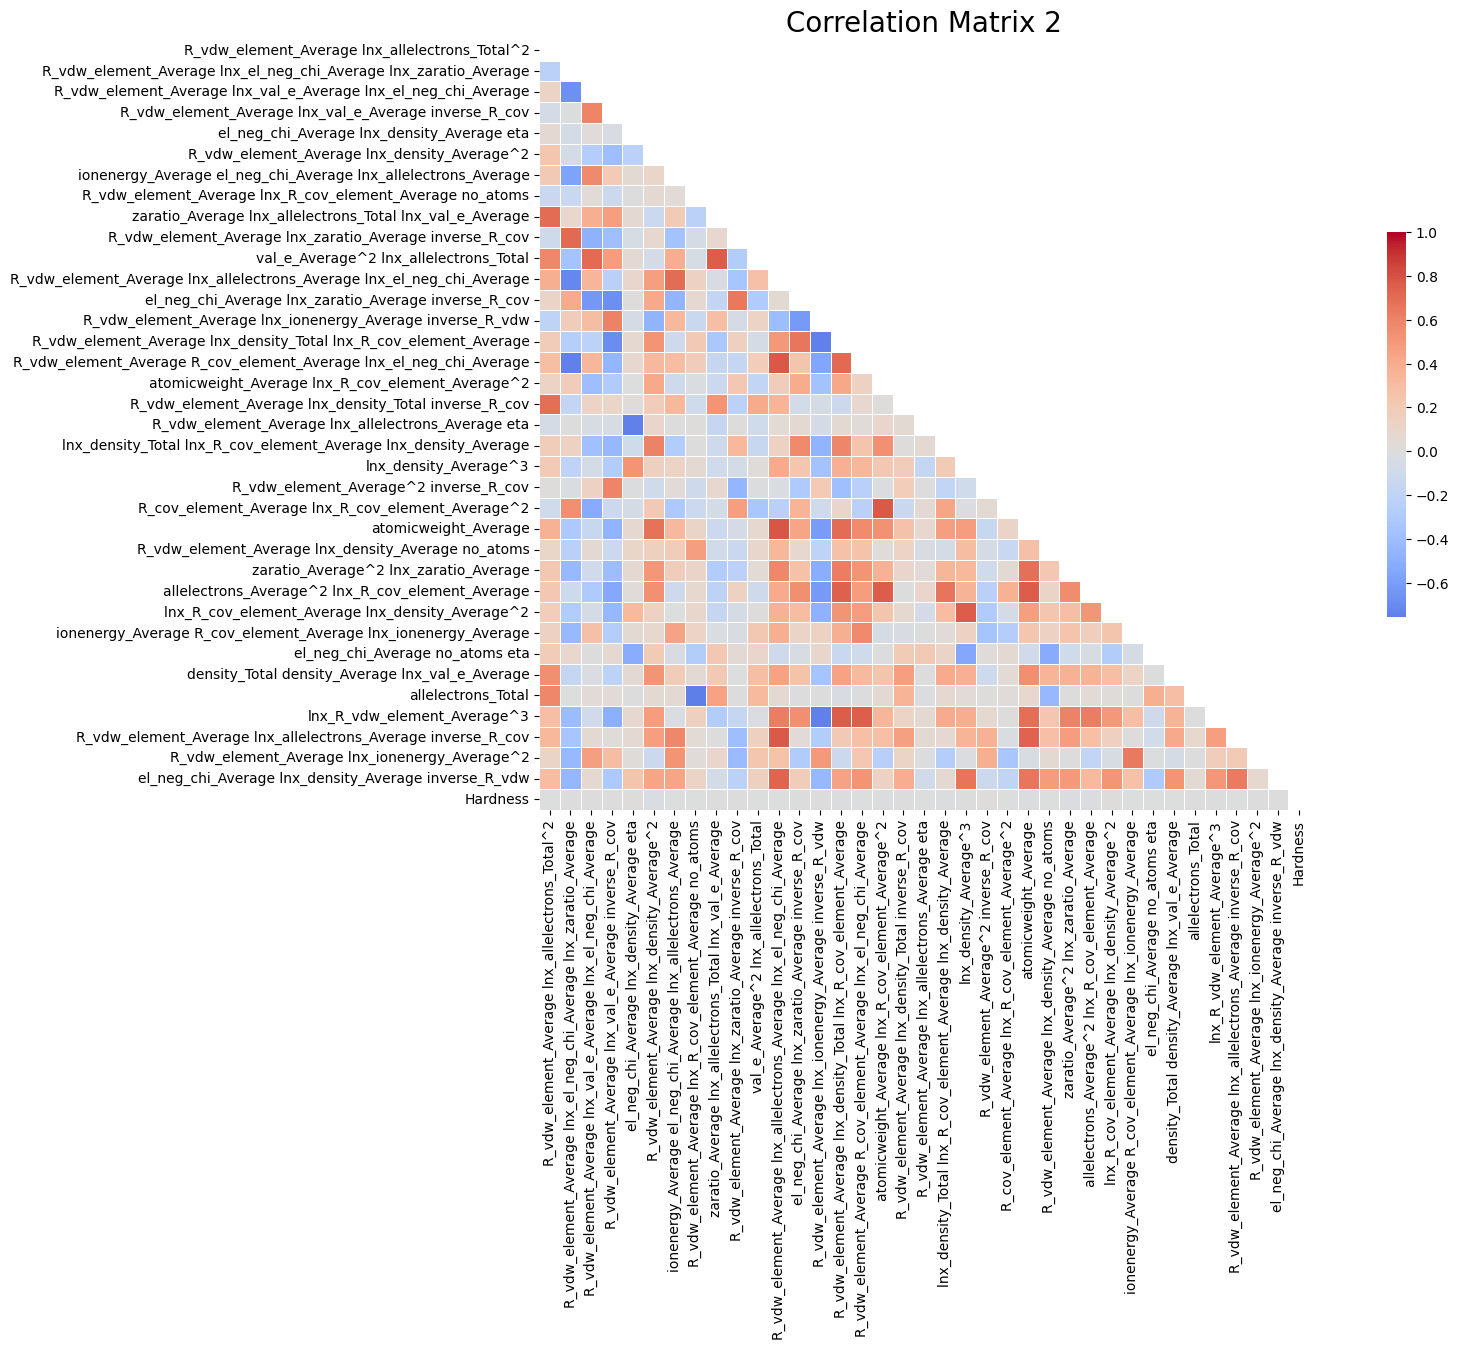

In [ ]:
_df = new_df[reduced_features_2]
# _df = new_df[_next]
_df['Hardness']= group1['Hardness']
corr = _df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            # annot=True, fmt=".1f"
            )

plt.title('Correlation Matrix 2', fontsize=20)
plt.savefig("Correlation matrix 2.png")
plt.show()

'R_vdw_element_Average lnx_val_e_Average lnx_el_neg_chi_Average', 'R_vdw_element_Average lnx_allelectrons_Average eta'

In [ ]:
important_features_model[important_features_model['Features'].isin(reduced_features_2)][:27]

,Features,Coefficient,L1 weightage,L2 weightage
1,R_vdw_element_Average lnx_allelectrons_Average...,-29.703376,0.061328,0.364186
11,allelectrons_Average^2 lnx_R_cov_element_Average,-12.293758,0.025383,0.150731
27,R_vdw_element_Average lnx_val_e_Average invers...,-5.788487,0.011951,0.070971
32,ionenergy_Average el_neg_chi_Average lnx_allel...,4.905541,0.010128,0.060146
34,atomicweight_Average lnx_R_cov_element_Average^2,4.822611,0.009957,0.059129
35,lnx_density_Total lnx_R_cov_element_Average ln...,-4.551561,0.009398,0.055806
37,R_vdw_element_Average lnx_val_e_Average lnx_el...,-4.163609,0.008597,0.051049
44,lnx_R_cov_element_Average lnx_density_Average^2,-3.044611,0.006286,0.037329
48,lnx_density_Average^3,-2.429069,0.005015,0.029782
50,ionenergy_Average R_cov_element_Average lnx_io...,-2.312298,0.004774,0.028351


In [ ]:
important_features[important_features['Features'].isin(reduced_features)]

,Features,Coefficient,L1 weightage
3,ionenergy_Average^3,-4.052318,0.051908
4,ionenergy_Average el_neg_chi_Average lnx_densi...,3.789425,0.048540
8,atomicweight_Average lnx_R_cov_element_Average^2,2.691990,0.034483
10,lnx_R_cov_element_Average^2 lnx_zaratio_Average,2.624378,0.033617
11,ionenergy_Average lnx_density_Total lnx_R_cov_...,2.128094,0.027260
16,lnx_density_Average^3,-1.608287,0.020601
19,density_Average^2 lnx_density_Average,1.056450,0.013533
24,zaratio_Average^2 lnx_zaratio_Average,0.879036,0.011260
25,ionenergy_Average R_cov_element_Average lnx_io...,0.832330,0.010662
26,zaratio_Average lnx_allelectrons_Total lnx_val...,-0.824626,0.010563


#### Partial Training

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

data_x=scaler.fit_transform(new_df[reduced_features_2])
data_y= group1['Hardness']
train_x, test_x, train_y, test_y = train_test_split(data_x,data_y, random_state=42)

In [ ]:
ls = Lasso(alpha=.0000001,max_iter=int(2e4))
ls.fit(train_x,train_y)
ls.score(train_x,train_y), ls.score(test_x,test_y)

(0.31789282356372595, 0.3226560131554882)

In [ ]:
ls.intercept_

12.463713785040033

In [ ]:
medAE(train_y,ls.predict(train_x)), medAE(test_y,ls.predict(test_x))

(0.8731758199813111, 0.8516465462169553)

(0.8899615366799232, 0.866057802544181)

(0.8881644933603887, 0.8701525264510988)

(0.873175679607046, 0.8516467336085376)


In [ ]:
def get_coefficient_importance(model,features):
    important_features_model  = pd.DataFrame({"Features": features,
                "Coefficient": model.coef_,
                "L1 weightage": np.abs(model.coef_)/np.sum(np.abs(model.coef_)),
                "L2 weightage": np.abs(model.coef_)/np.sum((model.coef_)**2)**.5,
                }).sort_values(by='Coefficient',key=lambda x: abs(x), ascending = False).reset_index(drop=True)
    return important_features_model
get_coefficient_importance(ls, reduced_features_2)

,Features,Coefficient,L1 weightage,L2 weightage
0,R_vdw_element_Average lnx_val_e_Average lnx_el...,12.251588,0.082455,0.393262
1,R_vdw_element_Average lnx_allelectrons_Average...,-11.253011,0.075735,0.361209
2,R_vdw_element_Average lnx_zaratio_Average inve...,-8.760224,0.058958,0.281193
3,val_e_Average^2 lnx_allelectrons_Total,-8.143329,0.054806,0.261392
4,R_vdw_element_Average lnx_ionenergy_Average in...,-7.511897,0.050556,0.241123
5,R_vdw_element_Average lnx_allelectrons_Average...,-7.507884,0.050529,0.240994
6,R_vdw_element_Average R_cov_element_Average ln...,-7.269326,0.048924,0.233337
7,atomicweight_Average lnx_R_cov_element_Average^2,6.746662,0.045406,0.216560
8,el_neg_chi_Average lnx_density_Average eta,-6.603439,0.044442,0.211963
9,el_neg_chi_Average lnx_zaratio_Average inverse...,6.325096,0.042569,0.203028


#### Another root with PCA

Key observation:
- PCA is going wrong.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
visualize = pca.fit_transform(new_df.drop('Hardness', axis=1))
visualize.shape

(10287, 50)

In [ ]:
# data_x=scaler.fit_transform(visualize)
# data_y= group1['Hardness']
# train_x, test_x, train_y, test_y = train_test_split(data_x,data_y, random_state=42)

In [ ]:
# len(train_x),len(train_y)

In [ ]:
# pca_lr = LinearRegression()
# pca_lr.fit(train_x,train_y)
# pca_lr.score(train_x,train_y), pca_lr.score(test_x,test_y)

In [ ]:
# plt.scatter(visualize[:,0],visualize[:,1], c = new_df['Hardness'], cmap= 'coolwarm')
# plt.colorbar()
# plt.show()

## Training

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

data_x=scaler.fit_transform(new_df[reduced_features_2])
data_y= group1['Hardness']
train_x, test_x, train_y, test_y = train_test_split(data_x,data_y,test_size=.2, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(data_x,data_y)
lr.score(data_x,data_y)

0.3208395315629081

In [ ]:
medAE(data_y, lr.predict(data_x))

0.877494214363546

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
lgm = LGBMRegressor(random_state=42)
lgm.fit(train_x,train_y)
lgm.score(train_x,train_y), lgm.score(test_x,test_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 36
[LightGBM] [Info] Start training from score 4.666459


(0.6874449878084672, 0.4699407351504209)

In [ ]:
medAE(train_y, lgm.predict(train_x)), medAE(test_y, lgm.predict(test_x))

(0.5143604099901977, 0.6351279905168954)

### Chosing Primary Model

In [ ]:
models ={
    'SVM-RBF' : SVR(),
    'SVM-Linear': SVR(kernel='linear'),
    'SVM-Poly': SVR(kernel='poly'),
    'Random Forest' : RandomForestRegressor(random_state=42),
    'GradientBoosting' : GradientBoostingRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
}
selection_primary_model(models,train_x,train_y, test_x, test_y, custom_scoring=medAE)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 8229, number of used features: 36
[LightGBM] [Info] Start training from score 4.666459


,model_name,train_score,test_score,custom_train_score,custom_test_score
3,Random Forest,0.921079,0.452119,0.257000,0.677000
6,XGBoost,0.897780,0.427260,0.271622,0.676439
5,LightGBM,0.687445,0.469941,0.514360,0.635128
2,SVM-Poly,0.331583,0.323995,0.688610,0.670142
4,GradientBoosting,0.498083,0.448015,0.689567,0.706412
0,SVM-RBF,0.316613,0.317909,0.706104,0.671326
1,SVM-Linear,0.281869,0.292261,0.760611,0.739610


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# gb = GradientBoostingRegressor(learning_rate= 0.05, loss= 'huber',
#                                max_depth= 4, max_features= 'sqrt',
#                                n_estimators= 800, random_state= 42)
# gb.fit(train_x,train_y)
# gb.score(train_x,train_y), gb.score(test_x,test_y)

In [ ]:
# medAE(train_y, gb.predict(train_x)), medAE(test_y, gb.predict(test_x))

In [ ]:
# medAE(data_y, gb.predict(data_x))

In [ ]:
model_properties= {
    'loss'        : [ 'squared_error', 'huber'],
    'learning_rate' : [ 0.01, .05],
    'n_estimators': [ 500, 800],
    # 'max_features': ['sqrt', 10, 13, 15],
    # 'max_depth'   : [3, 4],
    #   'alpha'       : [.1, .5, .9],
    'random_state': [42],
}
from sklearn.metrics import make_scorer
model_properties= {
    'loss'        :  ['huber'],
    'learning_rate' : [.002],
    'n_estimators':  [1600],
    'max_features': [9],
    'max_depth'   : [4],
    'subsample': [ 0.875],

      'alpha'       : [.995],
    'random_state': [42],
}
gb = GradientBoostingRegressor()
grid = GridSearchCV(gb,model_properties , cv=5,
                    scoring = make_scorer(medAE),
                    verbose=4)

In [ ]:
# grid.fit(train_x,train_y)
# grid.best_params_

In [ ]:
# grid.score(train_x,train_y), grid.score(test_x,test_y)

In [ ]:
# medAE(train_y, grid.predict(train_x)), medAE(test_y, grid.predict(test_x))

In [ ]:
# # plt.subplot(2,1,1)
# points =100
# plt.plot(range(points),train_y[:points],range(points), grid.predict(train_x[:points]),'--')
# plt.legend(['true','predicted'])
# plt.subplot(2,1,2)
# plt.plot(range(points),test_y[:points], range(points),grid.predict(test_x[:points]),'--')
# plt.legend(['true','predicted'])


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
# Step 1: Use KMeans++ to cluster the data into classes
n_clusters = 3 # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
# kmeans = Birch(n_clusters=None)
labels = kmeans.fit_predict(train_x)
# n_clusters = len(np.unique(labels))


# Step 2: Train a Gradient Boosting Regressor for each class
models = []
for cluster_label in range(n_clusters):
    # Select data points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    print(cluster_indices[-10:])
    X_cluster = train_x[cluster_indices]
    y_cluster = np.asarray(train_y)[cluster_indices]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    # Create a GradientBoostingRegressor for each class
    # regressor = GradientBoostingRegressor(
    #     alpha=0.995,
    #     learning_rate=0.002,
    #     loss='huber',
    #     max_depth=4,
    #     max_features=9,
    #     n_estimators=800,
    #     random_state=42,
    #     subsample = .875
    # )
    # regressor = LGBMRegressor(random_state=42)
    regressor = RandomForestRegressor(random_state=42)

    # Fit the model for the current class
    regressor.fit(X_train, y_train)
    models.append(regressor)





[8213 8214 8215 8216 8218 8220 8222 8225 8227 8228]
[8125 8127 8129 8139 8155 8160 8169 8176 8190 8221]
[8198 8199 8203 8205 8207 8217 8219 8223 8224 8226]


In [ ]:
# Step 3: Make predictions using the ensemble of regressors
def predict_ensemble(models, X):
    predictions = np.zeros((X.shape[0], len(models)))

    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)

    return np.median(predictions,axis=1)


In [ ]:
def predict_ensemble(models, X):
    label_predictions = kmeans.predict(X)
    predictions = np.zeros((X.shape[0]))
    for i in range((X.shape[0])):
        predictions[i] = models[label_predictions[i]].predict(X[i].reshape(1,-1))

    return predictions

In [ ]:
# Step 3: Make predictions using the ensemble of regressors
def predict_ensemble(models, X):
    predictions = np.zeros((X.shape[0], len(models)))
    label_predictions = kmeans.predict(X)
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X)

    return np.choose(label_predictions,predictions.T)


In [ ]:
# Make predictions on the entire dataset
train_y_pred = predict_ensemble(models, train_x)
medAE(train_y_pred,train_y)

0.3049999999999988

In [ ]:
# Make predictions on the entire dataset
test_y_pred = predict_ensemble(models, test_x)
medAE(test_y_pred,test_y)

0.6799999999999988

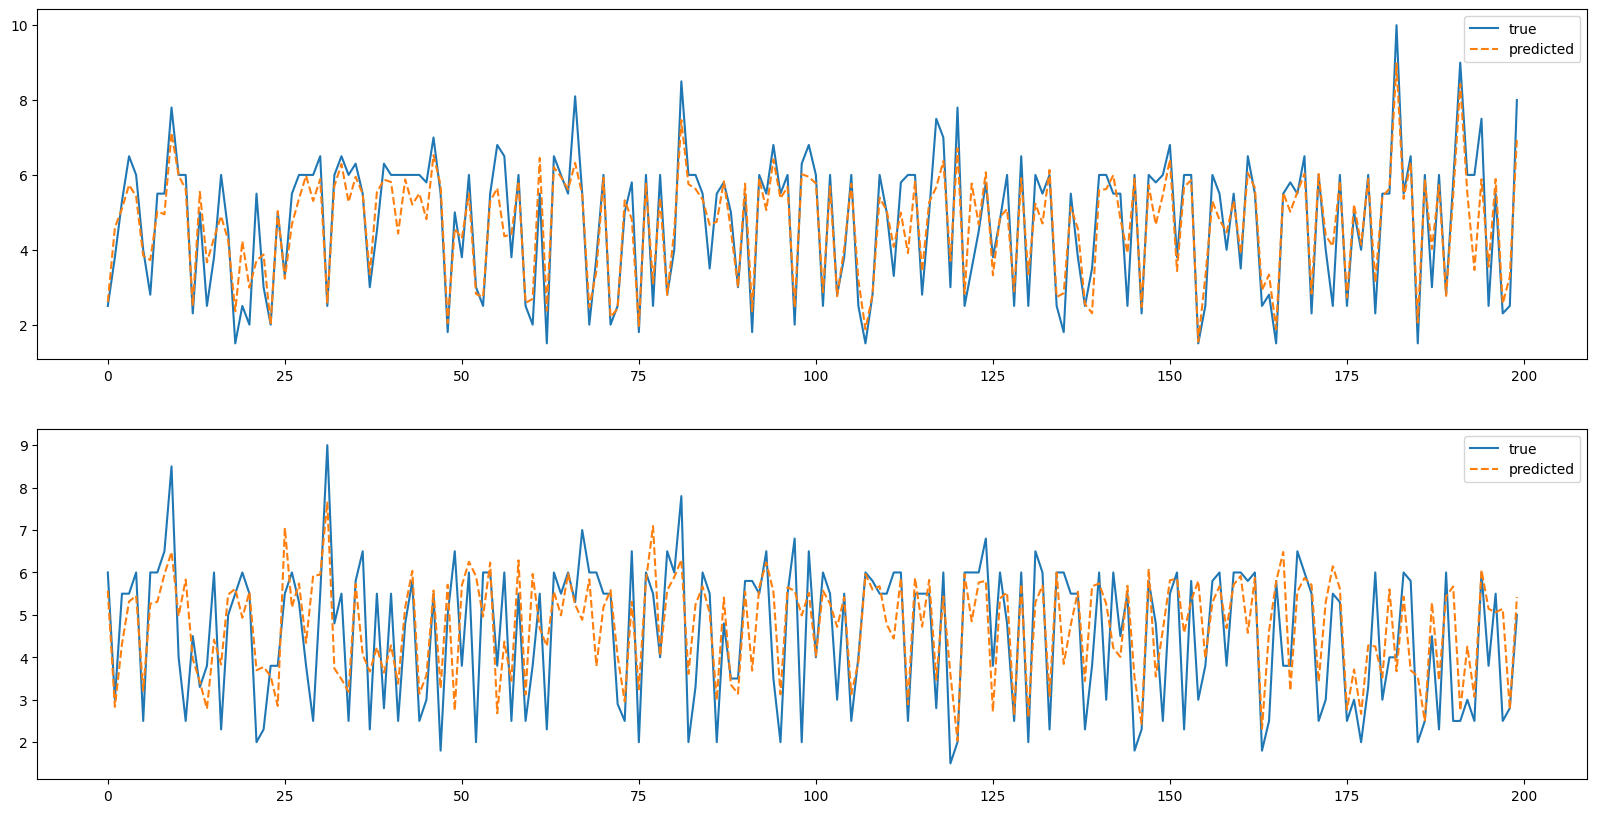

In [ ]:
train_test_prediction_plot(train_y,train_y_pred,test_y,test_y_pred,points=200)

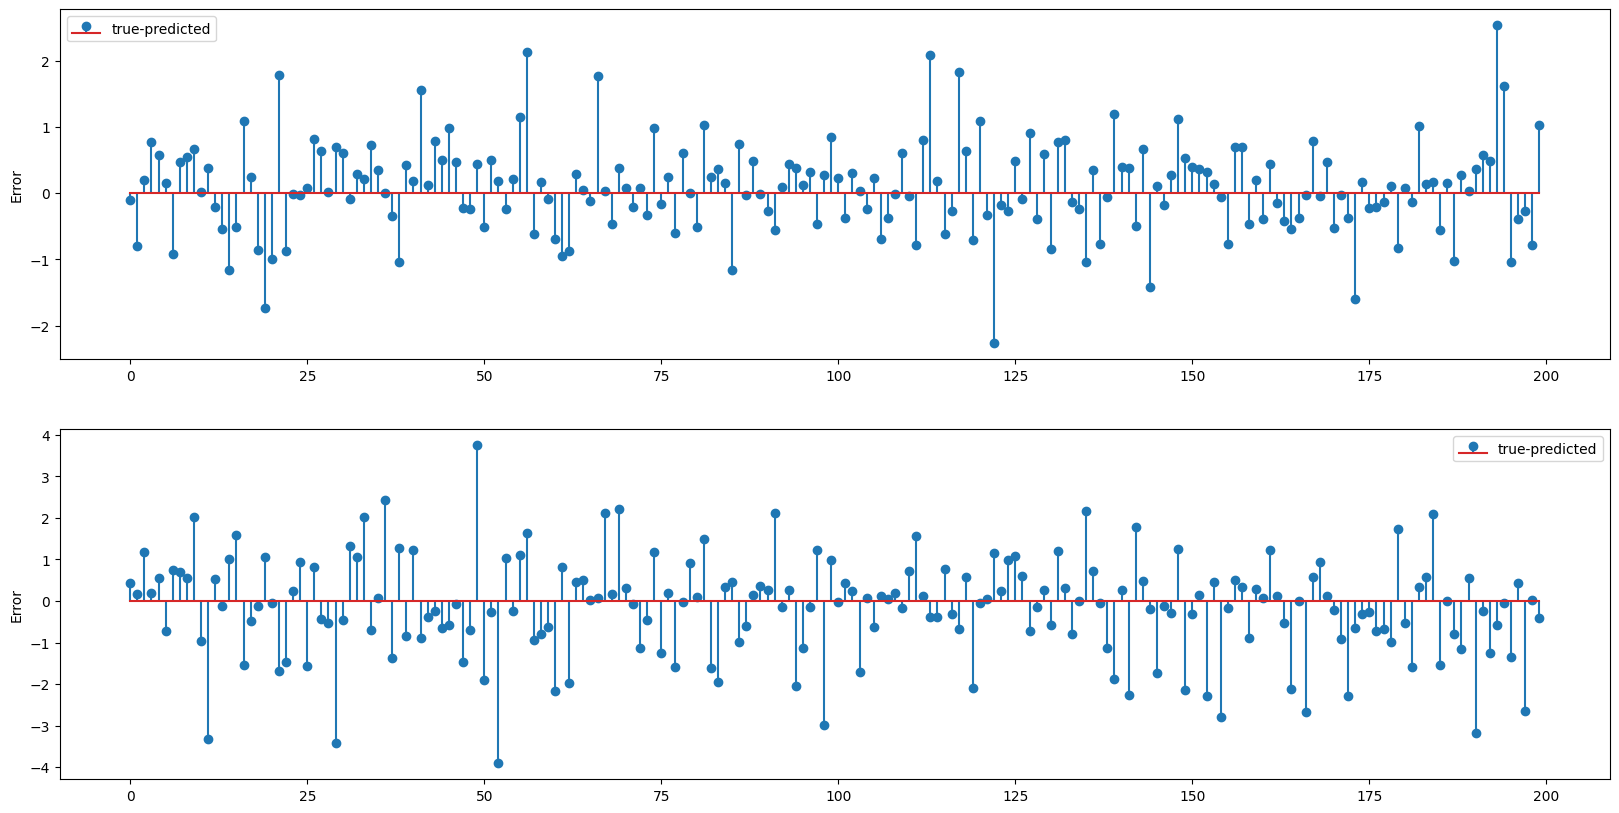

In [ ]:
error_plot(train_y, train_y_pred,points=200)

## Test Data

In [ ]:
submission = pd.DataFrame()

In [ ]:
test_df = pd.read_csv("test.csv")
submission['id']=test_df['id']
test_df.drop("id",axis=1,inplace=True)
test_df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [ ]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,6939.0,126.460128,207.564499,0.0,68.000000,100.000000,128.000000,10116.000000
density_Total,6939.0,14.794020,18.982447,0.0,7.558488,10.650000,16.601328,643.093804
allelectrons_Average,6939.0,17.406186,10.996089,0.0,10.000000,12.666667,22.000000,67.000000
val_e_Average,6939.0,4.546852,0.683158,0.0,4.000000,4.750000,4.800000,6.000000
atomicweight_Average,6939.0,38.422790,27.344351,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,6939.0,10.921512,1.378980,0.0,10.584314,11.202760,11.645560,15.245810
el_neg_chi_Average,6939.0,2.608119,0.322873,0.0,2.527500,2.706000,2.806667,3.443000
R_vdw_element_Average,6939.0,1.737907,0.190584,0.0,1.678000,1.736000,1.820000,2.250000
R_cov_element_Average,6939.0,0.949638,0.179266,0.0,0.866667,0.920000,0.990000,1.615333
zaratio_Average,6939.0,0.491675,0.060829,0.0,0.476095,0.488550,0.496118,0.825990


In [ ]:
(test_df==0).sum()

allelectrons_Total       47
density_Total            39
allelectrons_Average     45
val_e_Average            40
atomicweight_Average     45
ionenergy_Average        43
el_neg_chi_Average       36
R_vdw_element_Average    43
R_cov_element_Average    48
zaratio_Average          41
density_Average          33
dtype: int64

In [ ]:
(test_df==0).sum()/len(test_df)

allelectrons_Total       0.006773
density_Total            0.005620
allelectrons_Average     0.006485
val_e_Average            0.005765
atomicweight_Average     0.006485
ionenergy_Average        0.006197
el_neg_chi_Average       0.005188
R_vdw_element_Average    0.006197
R_cov_element_Average    0.006917
zaratio_Average          0.005909
density_Average          0.004756
dtype: float64

In [ ]:
z = pd.concat([pd.read_csv('Original.csv').drop('Hardness',axis=1),test_df])
len(pd.read_csv('Original.csv'))+6939-len(z.drop_duplicates())

42

the four
most important features are Features 7, 8, 3,and 5 with feature importances of 0.129, 0.113, 0.112,
and 0.111, respectively. These features correspond to the atomic average of the van der Waals atomic
radii, the atomic average of the covalent atomic radii, the atomic average of the valence electrons,and
the atomic average of IE, respectively

## Data submission

In [ ]:
# !kaggle competitions submit -c playground-series-s3e25 -f submission.csv -m "Message"

## Bibliography - Origial data processing

In [ ]:
# df1 =  pd.read_csv("Mineral_Dataset_Supplementary_Info.csv")
# df1 = df1[train_data.columns]
# df1.head()

In [ ]:
# df2 =  pd.read_csv("Artificial_Crystals_Dataset.csv")
# df2['Hardness']=df2['Hardness (Mohs)']
# df2 = df2[train_data.columns]
# df2.head()

In [ ]:
# df1.shape, df2.shape

In [ ]:
# df = pd.concat([df1,df2])
# df.shape

In [ ]:
# df.drop_duplicates(inplace=True)

In [ ]:
# df.shape

In [ ]:
# df.to_csv('Original.csv', index = False)